In [3]:
import torch
from pytorch_metric_learning import losses
import data_handler
from challenge_metrics import load_kpm_data
from siamese_network import SiameseNetwork, train, test, compute_metrics, extract_challenge_metrics
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from custom_losses import ContrastiveLoss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import itertools as it

/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
device = torch.device(2)

# Data Management

In [7]:
df_train, df_val, df_test = data_handler.load(path="dataset/", filename_train="train.csv", filename_dev="dev.csv", filename_test="test.csv", sep_char='#')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   arg_id        20635 non-null  object 
 1   argument      20635 non-null  object 
 2   key_point_id  20635 non-null  object 
 3   key_point     20635 non-null  object 
 4   topic         20635 non-null  object 
 5   stance        20635 non-null  int64  
 6   label         20635 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.1+ MB


In [9]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   arg_id        3458 non-null   object 
 1   argument      3458 non-null   object 
 2   key_point_id  3458 non-null   object 
 3   key_point     3458 non-null   object 
 4   topic         3458 non-null   object 
 5   stance        3458 non-null   int64  
 6   label         3458 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 189.2+ KB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   arg_id        3426 non-null   object 
 1   argument      3426 non-null   object 
 2   key_point_id  3426 non-null   object 
 3   key_point     3426 non-null   object 
 4   topic         3426 non-null   object 
 5   stance        3426 non-null   int64  
 6   label         3426 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 187.5+ KB


In [11]:
print(f"Number of unique topics present in Training set: {len(df_train['topic'].unique())}")
print(f"Number of unique topics present in Validation set: {len(df_val['topic'].unique())}")
print(f"Number of unique topics present in Test set: {len(df_test['topic'].unique())}")

Number of unique topics present in Training set: 24
Number of unique topics present in Validation set: 4
Number of unique topics present in Test set: 3


In [12]:
for elem in df_train['topic'].unique():
    print(f"# {elem}")
    print(df_train[df_train['topic'] == elem]['stance'].value_counts())

# Assisted suicide should be a criminal offence
 1    682
-1    345
Name: stance, dtype: int64
# Homeschooling should be banned
-1    655
 1    412
Name: stance, dtype: int64
# The vow of celibacy should be abandoned
-1    537
 1    533
Name: stance, dtype: int64
# We should abandon marriage
-1    480
 1    434
Name: stance, dtype: int64
# We should abolish capital punishment
 1    582
-1    478
Name: stance, dtype: int64
# We should abolish intellectual property rights
 1    423
-1    371
Name: stance, dtype: int64
# We should adopt atheism
 1    334
-1    274
Name: stance, dtype: int64
# We should adopt libertarianism
-1    419
 1    404
Name: stance, dtype: int64
# We should ban human cloning
-1    537
 1    406
Name: stance, dtype: int64
# We should ban private military companies
 1    516
-1    349
Name: stance, dtype: int64
# We should ban the use of child actors
-1    552
 1    532
Name: stance, dtype: int64
# We should close Guantanamo Bay detention camp
 1    623
-1    265
Nam

In [13]:
for elem in df_val['topic'].unique():
    print(f"# {elem}")
    print(df_val[df_val['topic'] == elem]['stance'].value_counts())

# We should abandon the use of school uniform
-1    544
 1    502
Name: stance, dtype: int64
# We should abolish the right to keep and bear arms
-1    451
 1    331
Name: stance, dtype: int64
# We should adopt an austerity regime
 1    492
-1    454
Name: stance, dtype: int64
# We should end affirmative action
 1    441
-1    243
Name: stance, dtype: int64


In [14]:
for elem in df_val['topic'].unique():
    print(f"# {elem}")
    print(df_val[df_val['topic'] == elem]['stance'].value_counts())

# We should abandon the use of school uniform
-1    544
 1    502
Name: stance, dtype: int64
# We should abolish the right to keep and bear arms
-1    451
 1    331
Name: stance, dtype: int64
# We should adopt an austerity regime
 1    492
-1    454
Name: stance, dtype: int64
# We should end affirmative action
 1    441
-1    243
Name: stance, dtype: int64


Percentage of 0 labels: 79.35546401744608
Percentage of 1 labels: 20.64453598255391


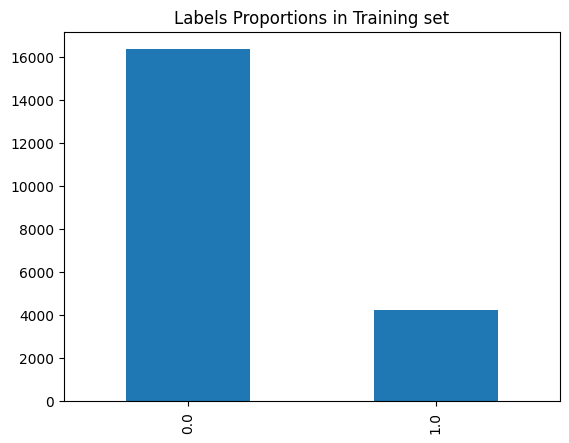

In [15]:
df_train['label'].value_counts().plot.bar(title='Labels Proportions in Training set')
values = df_train['label'].value_counts()
perc0 = values[0] / (values[0] + values[1])
print(f"Percentage of 0 labels: {perc0*100}")
print(f"Percentage of 1 labels: {(1-perc0)*100}")

Percentage of 0 labels: 78.65818392134182
Percentage of 1 labels: 21.341816078658184


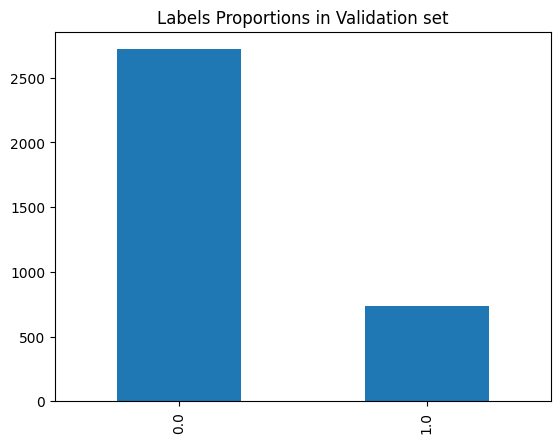

In [16]:
df_val['label'].value_counts().plot.bar(title='Labels Proportions in Validation set')
values = df_val['label'].value_counts()
perc0 = values[0] / (values[0] + values[1])
print(f"Percentage of 0 labels: {perc0*100}")
print(f"Percentage of 1 labels: {(1-perc0)*100}")

Percentage of 0 labels: 83.88791593695272
Percentage of 1 labels: 16.112084063047284


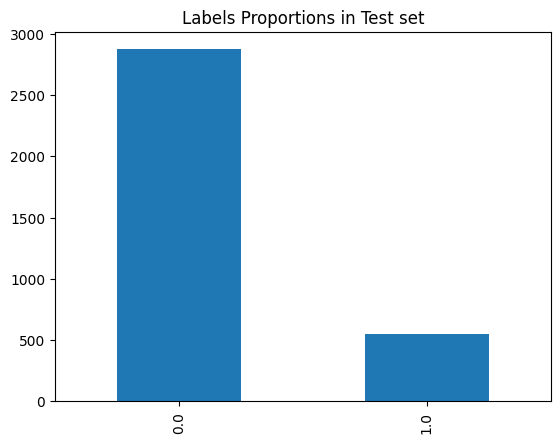

In [17]:
df_test['label'].value_counts().plot.bar(title='Labels Proportions in Test set')
values = df_test['label'].value_counts()
perc0 = values[0] / (values[0] + values[1])
print(f"Percentage of 0 labels: {perc0*100}")
print(f"Percentage of 1 labels: {(1-perc0)*100}")

In [18]:
#Check if there are some shared topics
print(f"Overlap of topics between Training and Validation: {len(np.intersect1d(df_train['topic'].unique(), df_val['topic'].unique()))}")
print(f"Overlap of topics between Training and Test: {len(np.intersect1d(df_train['topic'].unique(), df_test['topic'].unique()))}")
print(f"Overlap of topics between Test and Validation: {len(np.intersect1d(df_val['topic'].unique(), df_test['topic'].unique()))}")

Overlap of topics between Training and Validation: 0
Overlap of topics between Training and Test: 0
Overlap of topics between Test and Validation: 0


In [19]:
# Concatenate topics and keypoints, as stated in the paper
df_train = data_handler.concatenate_topics(df_train)
df_val = data_handler.concatenate_topics(df_val)
df_test = data_handler.concatenate_topics(df_test)

In [20]:
n_words = pd.DataFrame()
n_words['words_per_arg_train'] = df_train['argument'].str.split().apply(len)
n_words['words_per_arg_val'] = df_val['argument'].str.split().apply(len)
n_words['words_per_arg_test'] = df_test['argument'].str.split().apply(len)
n_words['words_per_kp_train'] = df_train['key_points'].str.split().apply(len)
n_words['words_per_kp_val'] = df_val['key_points'].str.split().apply(len)
n_words['words_per_kp_test'] = df_test['key_points'].str.split().apply(len)

Considerazioni varie...

<AxesSubplot: >

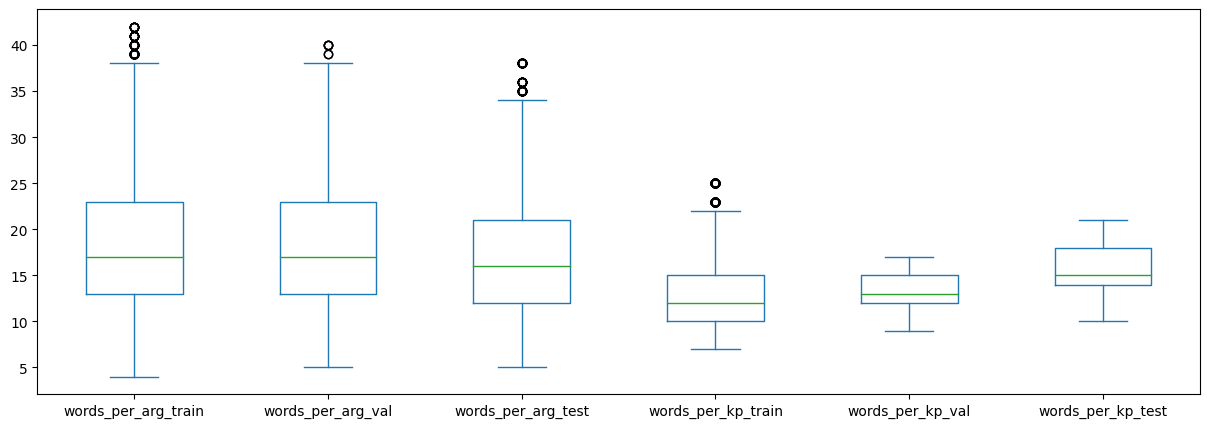

In [21]:
n_words.plot.box(figsize=(15, 5))

In [24]:
print(f"Max number of words for Training args: {n_words['words_per_arg_train'].max()}")
print(f"Max number of words for Validation args: {n_words['words_per_arg_val'].max()}")
print(f"Max number of words for Test args: {n_words['words_per_arg_test'].max()}\n")

print(f"Max number of words for Training key points: {n_words['words_per_kp_train'].max()}")
print(f"Max number of words for Validation key points: {n_words['words_per_kp_val'].max()}")
print(f"Max number of words for Validation key points: {n_words['words_per_kp_test'].max()}")

Max number of words for Training args: 42
Max number of words for Validation args: 40.0
Max number of words for Test args: 38.0

Max number of words for Training key points: 25
Max number of words for Validation key points: 17.0
Max number of words for Validation key points: 21.0


In [25]:
# Load our model's (bert-base-uncased) tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize data
max_length = 60
columns_list = ['argument', 'key_points', 'label']
tokenized_tr = data_handler.tokenize_df(df_train[columns_list], tokenizer, max_length=max_length)
tokenized_val = data_handler.tokenize_df(df_val[columns_list], tokenizer, max_length=max_length)
tokenized_test = data_handler.tokenize_df(df_test[columns_list], tokenizer, max_length=max_length)

/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_len

In [26]:
print(f'Vocabulary size of tokenizer:', tokenizer.vocab_size, '\nContext size:', max_length)

Vocabulary size of tokenizer: 30522 
Context size: 60


In [ ]:
tokenized_tr

In [ ]:
# Tokenizing without padding to check token lengths
args_len = [len(tokenizer.encode(s)) for s in df_train['argument']]
kps_len = [len(tokenizer.encode(s)) for s in df_train['key_points']]

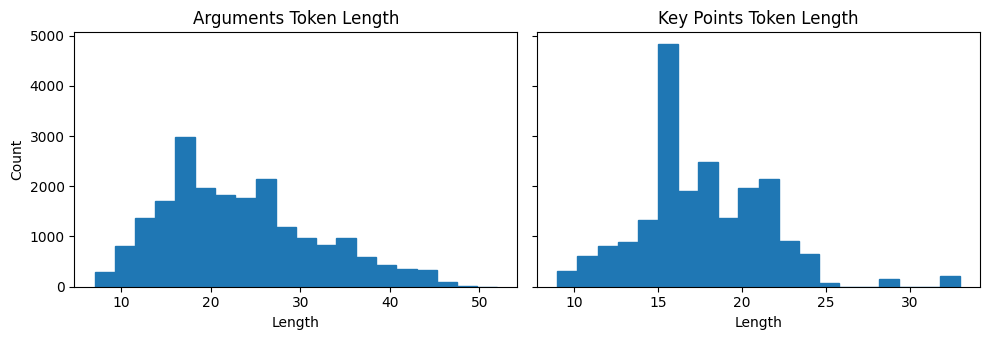

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(args_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Arguments Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(kps_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Key Points Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()